### Import Libraries

In [7]:
#Libs
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import Isomap
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from collections import defaultdict

### Import Data

In [8]:
#data
dim_cd_df = pd.read_csv('../data/interim_data/dim_cd_df.csv',index_col=0)
dim_qq_df = pd.read_csv('../data/interim_data/dim_qq_df.csv',index_col=0)
FACT_df = pd.read_csv('../data/interim_data/FACT_df.csv',index_col=0)

### Subset and Merge Data

Since the data contains multiple languages and google translation services cost a fee, I'll subset the data to just us locations

In [9]:
#Subset the Fact table for only data from the US for 2020 and remove rows where the answer was NA
us_data = pd.merge(FACT_df,dim_cd_df[['Account_Num','Country','geometry']],on='Account_Num')

us_data.drop_duplicates(inplace=True)
us_data=us_data.query("Country == 'United States of America' & \
            Year ==2020 & \
            Answer not in ['Question not applicable','nan']")

#merge with dim_qq_df to add "Sect" to our df
us_data = pd.merge(us_data,dim_qq_df[['Question_ID','Sect']],on='Question_ID')

#drop null from answer
us_data.dropna(inplace=True)

In [10]:
#sample 5000 rows
us_data_sample = us_data.sample(5000).reset_index(drop=True)

us_data_sample.shape

(5000, 7)

In [11]:
len(us_data_sample.Sect.unique())

25

In [12]:
us_data_sample.Answer=us_data_sample.Answer.astype('str')

#  New Questions to Ask

## - What words are most prevelant in each section?
## - Are there clusters within the 'answers' feature?
## - If so, can we classify those clusters (per section)?
## - What does one cluster group per sector look like on a map?

##  What words are most prevelant in each section?

In [13]:
#!pip install spaCy           --install packages
#!python -m spacy download en_core_web_md    #--download english model

In [14]:
#use the medium sized model for vectorization
nlp = spacy.load("en_core_web_md")

In [15]:
#generate a corpus of answers
docs = list(nlp.pipe(us_data_sample.Answer))

In [16]:
#create a function to extract spacy attributes
def extract_tokens_plus_meta(doc:spacy.tokens.doc.Doc):
    """Extract tokens and metadata from individual spaCy doc."""
    return [
        (i.text, i.i, i.lemma_.lower(), i.ent_type_, i.tag_, 
         i.dep_, i.pos_, i.is_stop, i.is_alpha, 
         i.is_digit, i.is_punct) for i in doc
    ]

In [17]:
#create a df of those attributes
def tidy_tokens(docs):
    """Extract tokens and metadata from list of spaCy docs."""
    
    cols = [
        "doc_id", "token", "token_order", "lemma", 
        "ent_type", "tag", "dep", "pos", "is_stop", 
        "is_alpha", "is_digit", "is_punct"
    ]
    
    meta_df = []
    for ix, doc in enumerate(docs):
        meta = extract_tokens_plus_meta(doc)
        meta = pd.DataFrame(meta)
        meta.columns = cols[1:]
        meta = meta.assign(doc_id = ix).loc[:, cols]
        meta_df.append(meta)
        
    return pd.concat(meta_df).reset_index(drop=True)

In [18]:
#create a new table of our answers broken down by spaCy attributes
tidy_doc = tidy_tokens(docs)
tidy_doc.head()

doc_id       token  token_order       lemma ent_type tag     dep    pos  \
0       0  Especially            0  especially           RB  advmod    ADV   
1       0        with            1        with           IN    prep    ADP   
2       0       covid            2       covid           NN    amod   NOUN   
3       0         and            3         and           CC      cc  CCONJ   
4       0      recent            4      recent           JJ    conj    ADJ   

   is_stop  is_alpha  is_digit  is_punct  
0    False      True     False     False  
1     True      True     False     False  
2    False      True     False     False  
3     True      True     False     False  
4    False      True     False     False

In [19]:
#Add an index to our US data
us_data_sample=us_data_sample.reset_index()

In [20]:
#merge to add question id and geometry
df_merge = pd.merge(tidy_doc,us_data_sample[['index','Sect','geometry']], 
                    left_on ='doc_id',right_on='index')
#drop the duplicate column 
df_merge.drop(columns='index',inplace=True)

#reorder
df_merge=df_merge[['Sect','doc_id','geometry',
                   'token','token_order','lemma',
                   'ent_type','tag','dep',
                   'pos','is_stop','is_alpha',
                   'is_digit','is_punct']]

In [21]:
#Now we can sort by Question ID
df_merge.sort_values(['Sect','doc_id','token_order']).head()

Sect  doc_id                  geometry       token  \
54  Adaptation Actions       1  POINT (-95.3694 29.7602)    Enhanced   
55  Adaptation Actions       1  POINT (-95.3694 29.7602)  resilience   
56  Adaptation Actions       1  POINT (-95.3694 29.7602)           ,   
57  Adaptation Actions       1  POINT (-95.3694 29.7602)    Improved   
58  Adaptation Actions       1  POINT (-95.3694 29.7602)    resource   

    token_order       lemma ent_type  tag       dep    pos  is_stop  is_alpha  \
54            0     enhance           VBN      amod   VERB    False      True   
55            1  resilience            NN      ROOT   NOUN    False      True   
56            2           ,             ,     punct  PUNCT    False     False   
57            3    improved            JJ      amod    ADJ    False      True   
58            4    resource            NN  compound   NOUN    False      True   

    is_digit  is_punct  
54     False     False  
55     False     False  
56     False      True  
57     False     False  
58     False     False

In [22]:
#lets investigate the POS of 'SPACE'
#this will take the spaces and place the "prevous and next tokens" around the space. 
(df_merge
 .groupby("doc_id")
 .apply(lambda x: x.assign(
     prev_token = lambda x: x.token.shift(1), 
     next_token = lambda x: x.token.shift(-1))
       )
 .reset_index(drop=True)
 .query("pos == 'SPACE'")
 .loc[:, ["doc_id", "prev_token", "token", "next_token"]]
).head()

doc_id prev_token token  \
490       28          .         
974       82          .         
1006      82          .         
1105      87          .         
1281     102          /         

                                             next_token  
490                                                 The  
974                                        Additionally  
1006                                            Further  
1105                                            Current  
1281  https://www.weho.org/city-government/city-depa...

the space is just a typo error of an additional space

In [23]:
#Subset DF to remove stopwords, punctuation and SPACE p.o.s
df_merge_simplified=df_merge.query("is_stop == False & is_punct == False & pos != 'SPACE'")
df_merge_simplified

Sect  doc_id                  geometry  \
0                      Climate Hazards       0  POINT (-122.031 36.9741)   
2                      Climate Hazards       0  POINT (-122.031 36.9741)   
4                      Climate Hazards       0  POINT (-122.031 36.9741)   
5                      Climate Hazards       0  POINT (-122.031 36.9741)   
7                      Climate Hazards       0  POINT (-122.031 36.9741)   
...                                ...     ...                       ...   
68372                  Climate Hazards    4997   POINT (-79.792 36.0726)   
68374  City-wide external verification    4999  POINT (-97.1331 33.2148)   
68376  City-wide external verification    4999  POINT (-97.1331 33.2148)   
68380  City-wide external verification    4999  POINT (-97.1331 33.2148)   
68381  City-wide external verification    4999  POINT (-97.1331 33.2148)   

            token  token_order       lemma ent_type  tag     dep   pos  \
0      Especially            0  especially            RB  advmod   ADV   
2           covid            2       covid            NN    amod  NOUN   
4          recent            4      recent            JJ    conj   ADJ   
5           fires            5        fire           NNS    pobj  NOUN   
7            Lack            7        lack            NN   nsubj  NOUN   
...           ...          ...         ...      ...  ...     ...   ...   
68372      Medium            0      medium            JJ    ROOT   ADJ   
68374   Intending            0      intend           VBG    ROOT  VERB   
68376   undertake            2   undertake            VB   xcomp  VERB   
68380           2            6           2     DATE   CD  nummod   NUM   
68381       years            7        year     DATE  NNS    pobj  NOUN   

       is_stop  is_alpha  is_digit  is_punct  
0        False      True     False     False  
2        False      True     False     False  
4        False      True     False     False  
5        False      True     False     False  
7        False      True     False     False  
...        ...       ...       ...       ...  
68372    False      True     False     False  
68374    False      True     False     False  
68376    False      True     False     False  
68380    False     False      True     False  
68381    False      True     False     False  

[41077 rows x 14 columns]

### Text Exploration

In [24]:
#How many unique sectors are there?
len(df_merge_simplified.Sect.unique())

25

In [25]:
#unique lemma per sector
unique_lemma = df_merge_simplified.groupby('Sect')['lemma'].nunique().sort_values(ascending=False)
unique_lemma.head(10)

Sect
Mitigation Actions                    1773
Climate Hazards                       1352
Adaptation Actions                    1317
Governance                             875
Finance and Economic Opportunities     782
Opportunities                          780
Adaptation Planning                    751
City-wide GHG Emissions Data           725
Water Supply Management                697
Collaboration                          625
Name: lemma, dtype: int64

In [26]:
#number of different doc_id per group
unique_doc_id = df_merge_simplified.groupby('Sect')['doc_id'].nunique().sort_values(ascending=False)
unique_doc_id

Sect
Climate Hazards                                   921
Mitigation Actions                                671
City-wide GHG Emissions Data                      666
Adaptation Actions                                580
GCoM Emission Factor and Activity Data            300
Mitigation Target setting                         194
Finance and Economic Opportunities                192
Water Supply Management                           151
Climate Risk and Vulnerability Assessment         142
Mitigation Planning                               124
Adaptation Planning                               116
Adaptation Goals                                  113
Historical emissions inventories                  111
Governance                                        104
City Details                                      103
Opportunities                                     101
Water Supply                                      100
Collaboration                                      79
Local Government Operat

Intersting to see the few responses for sectors such as urban planning, data management, and adaptation planning processes. We will subset these values for sectors with more than 20 responses

In [27]:
unique_doc_id = unique_doc_id.loc[unique_doc_id.values > 20].sort_values(ascending=False)
unique_doc_id.head(10)

Sect
Climate Hazards                              921
Mitigation Actions                           671
City-wide GHG Emissions Data                 666
Adaptation Actions                           580
GCoM Emission Factor and Activity Data       300
Mitigation Target setting                    194
Finance and Economic Opportunities           192
Water Supply Management                      151
Climate Risk and Vulnerability Assessment    142
Mitigation Planning                          124
Name: doc_id, dtype: int64

In [28]:
#The average number of unique Lemma per answer
words_per_id = unique_lemma/unique_doc_id
words_per_id = (words_per_id.loc[words_per_id.notnull()].sort_values(ascending=False)).astype('int')
words_per_id.head(10)

Sect
Governance                                   8
Collaboration                                7
Opportunities                                7
Adaptation Planning                          6
Adaptation Goals                             5
Water Supply Management                      4
Climate Risk and Vulnerability Assessment    4
Water Supply                                 4
Finance and Economic Opportunities           4
Mitigation Planning                          2
dtype: int64

In [29]:
#subset our data to important features
data_sect_id_pos_lemma =df_merge_simplified[['Sect','doc_id','pos','lemma']]\
                        .sort_values(['Sect','doc_id','pos'])
data_sect_id_pos_lemma

Sect  doc_id   pos       lemma
57          Adaptation Actions       1   ADJ    improved
61          Adaptation Actions       1   ADV        e.g.
55          Adaptation Actions       1  NOUN  resilience
58          Adaptation Actions       1  NOUN    resource
59          Adaptation Actions       1  NOUN  efficiency
...                        ...     ...   ...         ...
68109  Water Supply Management    4968  VERB     include
68113  Water Supply Management    4968  VERB    increase
68132  Water Supply Management    4968  VERB    generate
68149  Water Supply Management    4968  VERB       focus
68157  Water Supply Management    4968  VERB       yield

[41077 rows x 4 columns]

In [30]:
#Count of words per sector. Lets remove those with less than 30 words

#subset the table above for section and lemma
lemma_counts =data_sect_id_pos_lemma[['Sect','lemma']]

#group by Sect, count # of lemma, and sort values 
lemma_counts_grouped = lemma_counts.groupby('Sect',as_index=False)\
                        .lemma.count()\
                        .sort_values('lemma',ascending=False)

#create a list of counts above 30. Anything less won't be great for analysis
sects_over_30 = list(lemma_counts_grouped.loc[lemma_counts_grouped.lemma > 30].Sect)

#show the first 10 rows
sects_over_30[:10]

['Climate Hazards',
 'Mitigation Actions',
 'Adaptation Actions',
 'Governance',
 'City-wide GHG Emissions Data',
 'Adaptation Planning',
 'Opportunities',
 'Adaptation Goals',
 'Finance and Economic Opportunities',
 'Water Supply Management']

In [31]:
#show a table of our sectors with over 30 lemma 
lemma_counts_grouped_w_rank= lemma_counts.groupby('Sect',as_index=False).lemma.value_counts()
lemma_counts_grouped_w_rank_30=lemma_counts_grouped_w_rank.loc[lemma_counts_grouped_w_rank.Sect.isin(sects_over_30)]

lemma_counts_grouped_w_rank_30

Sect           lemma  count
0           Adaptation Actions           water    139
1           Adaptation Actions  infrastructure     73
2           Adaptation Actions            city     69
3           Adaptation Actions               >     68
4           Adaptation Actions          public     61
...                        ...             ...    ...
13061  Water Supply Management          indoor      1
13062  Water Supply Management        indicate      1
13063  Water Supply Management     incorporate      1
13064  Water Supply Management          income      1
13065  Water Supply Management     incentivize      1

[13043 rows x 3 columns]

In [32]:
#Let's add a dense rank so we can eventually pull out the top 30 words per sector  

#group by Section, and get VALUE_COUNTS of lemma (different than above)
lemma_counts_grouped_w_rank= lemma_counts.groupby('Sect',as_index=False).lemma.value_counts()

#subet the sections for only thoe in sects_over_30.
lemma_counts_grouped_w_rank_30=lemma_counts_grouped_w_rank_30.loc\
            [lemma_counts_grouped_w_rank_30.Sect.isin(sects_over_30)]

#Add a rank so we can subset for top 30 by sector (Dense rank)
lemma_counts_grouped_w_rank_30['dense_rank'] = lemma_counts_grouped_w_rank_30\
            .sort_values(['Sect','count'], ascending=[True,False]) \
            .groupby(['Sect'])['count']\
            .rank(method='dense', ascending=False) \
            .astype(int)

#filter for dense_rank <=30. We only want top 30 words
lemma_counts_grouped_w_rank_30 = lemma_counts_grouped_w_rank_30.loc[lemma_counts_grouped_w_rank_30.dense_rank <=30]
lemma_counts_grouped_w_rank_30


Sect           lemma  count  dense_rank
0           Adaptation Actions           water    139           1
1           Adaptation Actions  infrastructure     73           2
2           Adaptation Actions            city     69           3
3           Adaptation Actions               >     68           4
4           Adaptation Actions          public     61           5
...                        ...             ...    ...         ...
13061  Water Supply Management          indoor      1          19
13062  Water Supply Management        indicate      1          19
13063  Water Supply Management     incorporate      1          19
13064  Water Supply Management          income      1          19
13065  Water Supply Management     incentivize      1          19

[8749 rows x 4 columns]

In [33]:
len(lemma_counts_grouped_w_rank_30.Sect.unique())

24

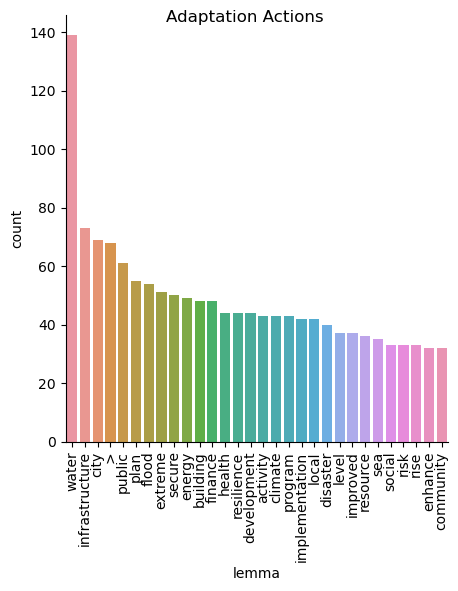

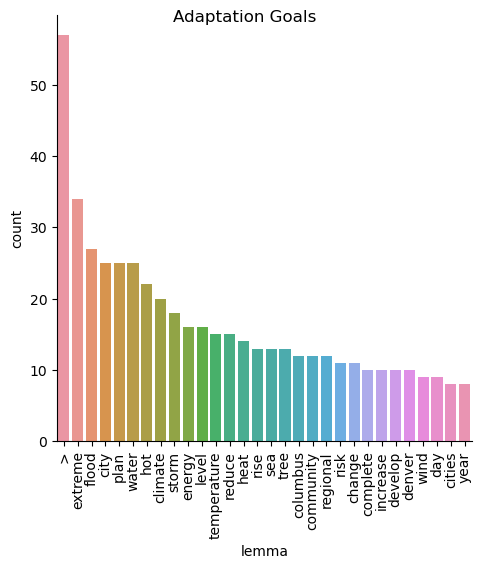

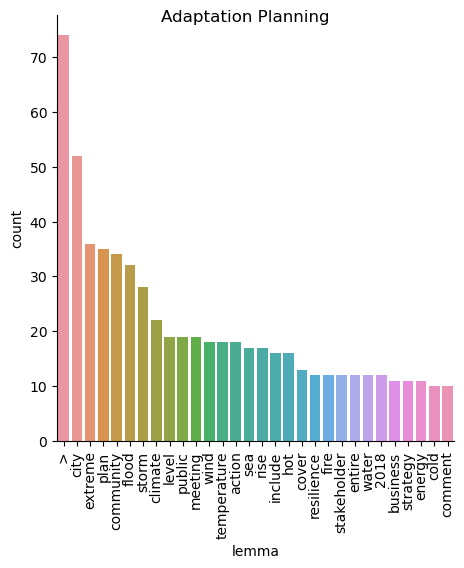

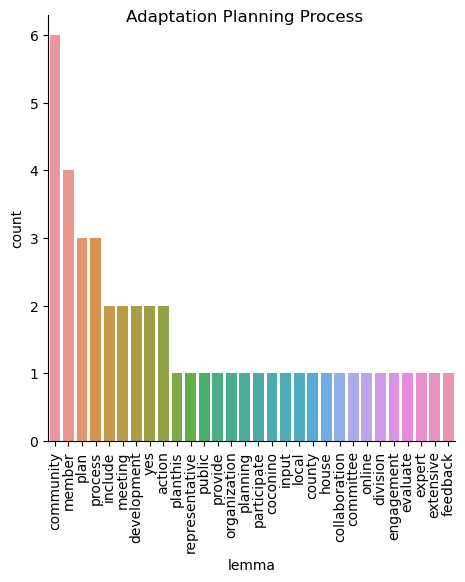

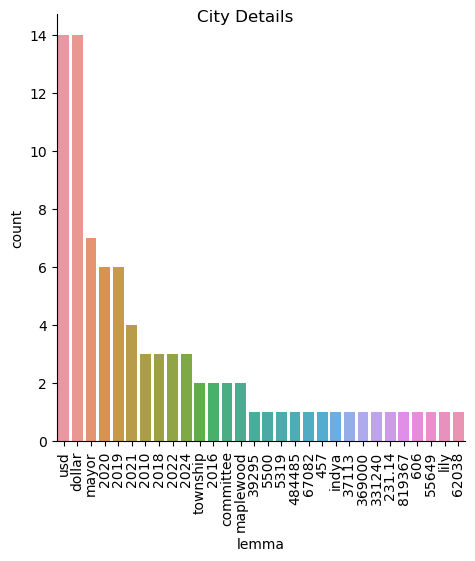

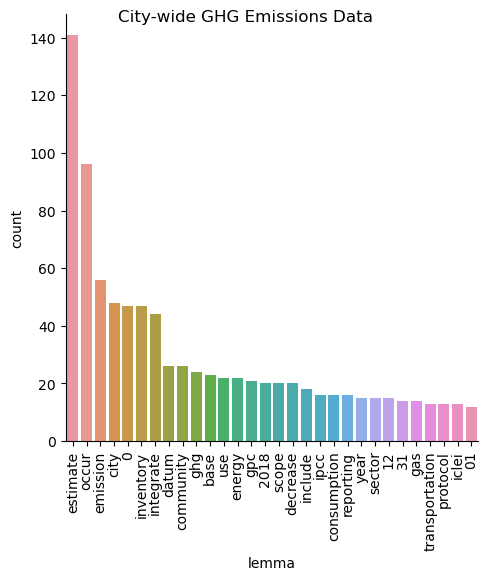

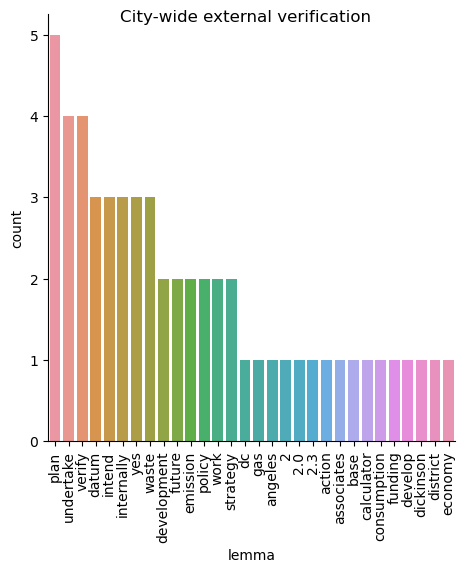

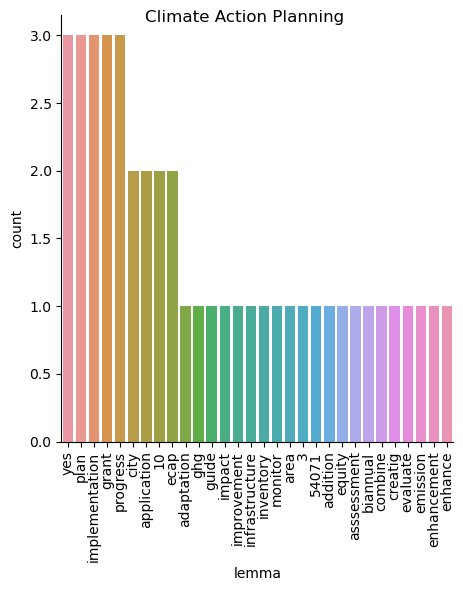

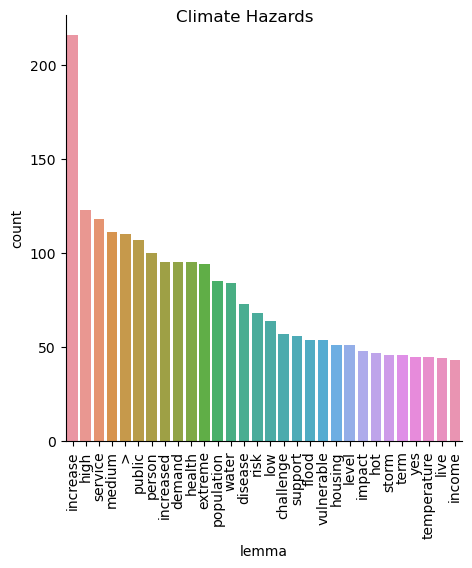

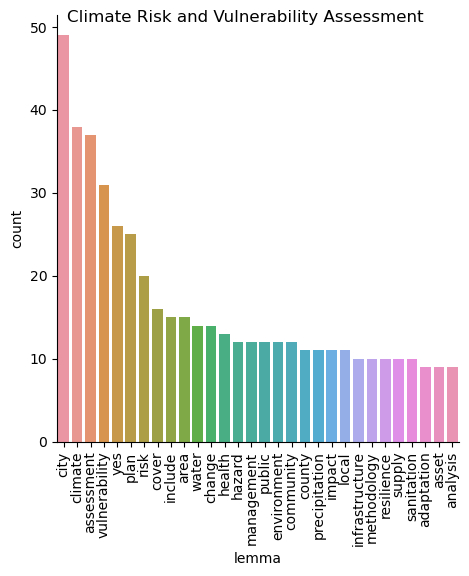

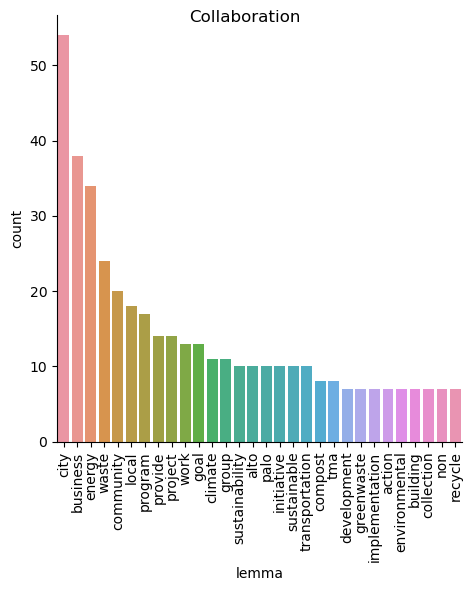

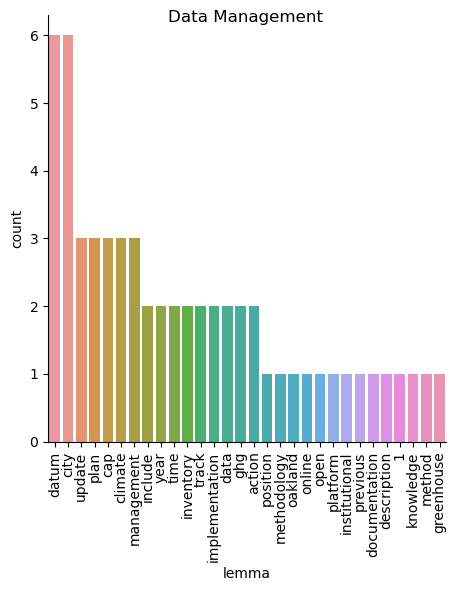

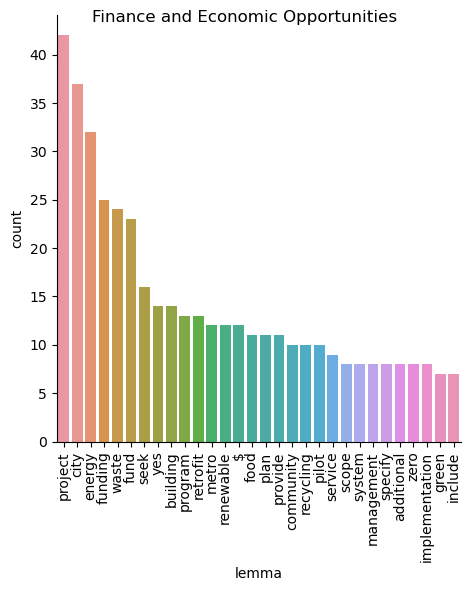

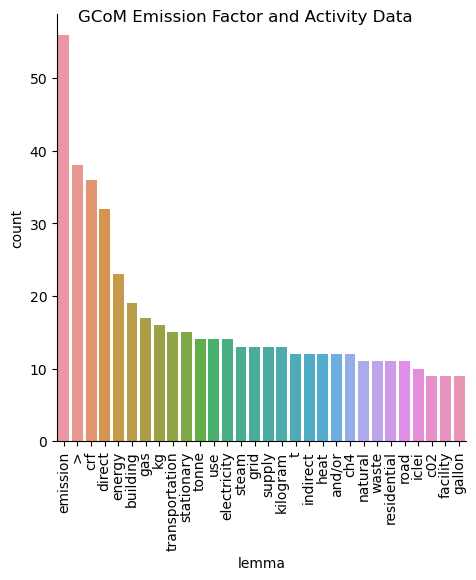

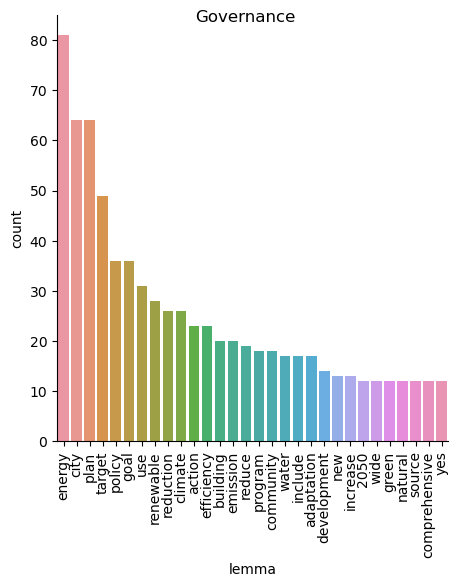

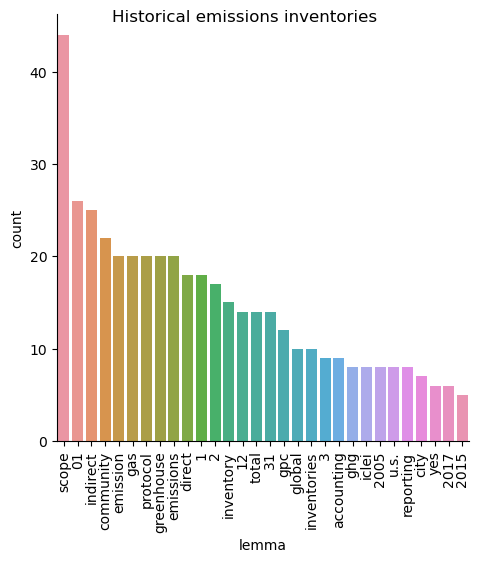

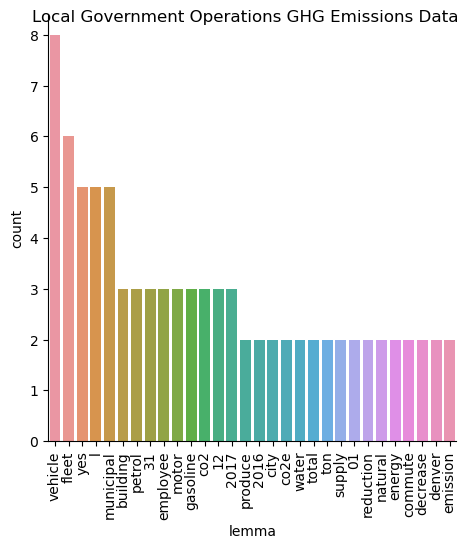

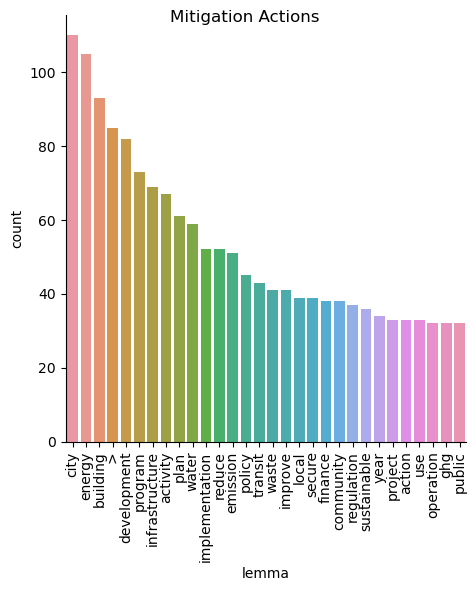

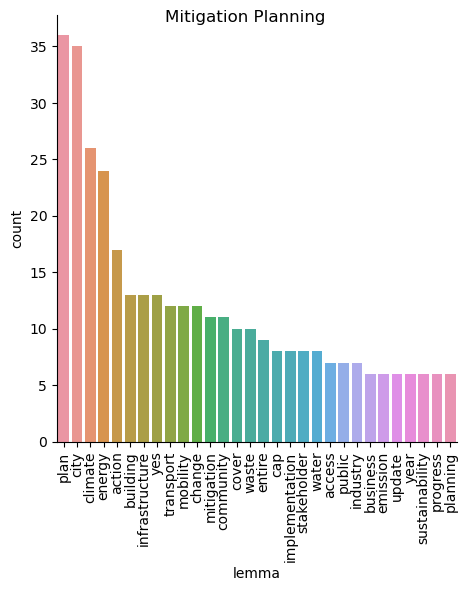

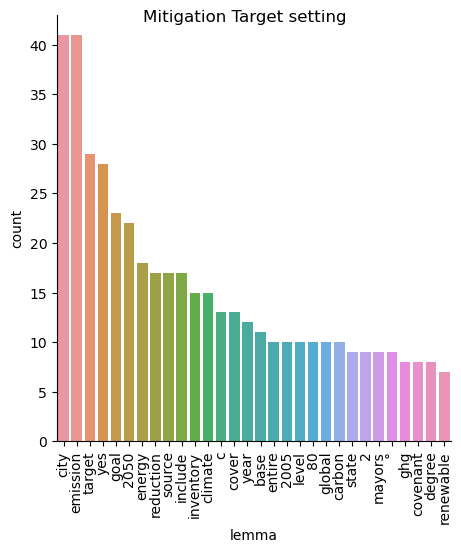

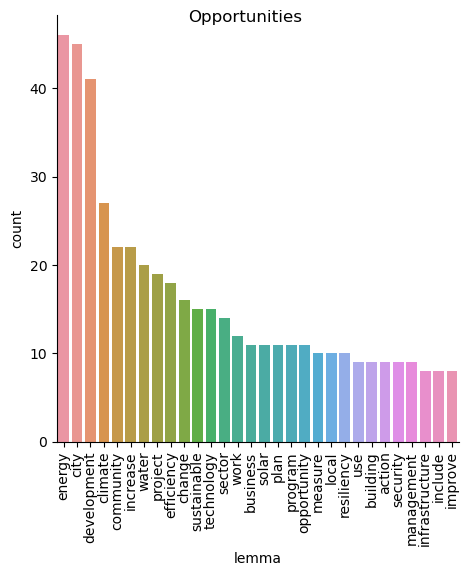

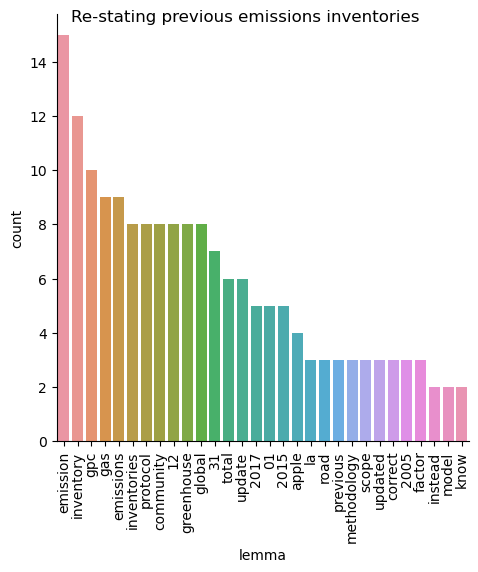

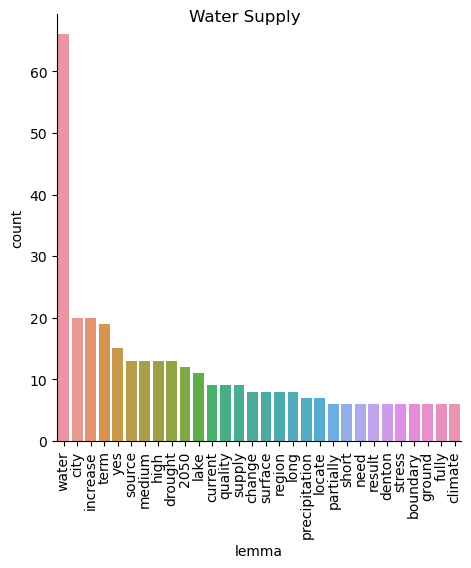

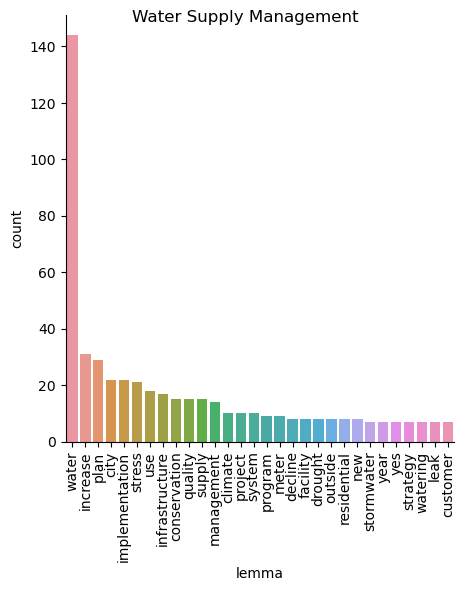

In [34]:
#Counts of top 30 lemma by subsector- graphs (just show 30 )

#for each section, create a plot
for sect in lemma_counts_grouped_w_rank_30.Sect.unique():
    
    #bar plot
    p=sns.catplot(kind='bar',\
                  data=lemma_counts_grouped_w_rank.loc[lemma_counts_grouped_w_rank.Sect==sect].sort_values("count",ascending=False).head(30),
                  x='lemma',
                  y='count')
    p.fig.suptitle(sect)
    p.set_xticklabels(rotation=90)
plt.show()

### We now have most common words per sector

In [35]:
#lets compress the data frame. for each sector, create a list of the lemmas
lemma_counts_grouped_w_rank_30_list = lemma_counts_grouped_w_rank_30.groupby('Sect')['lemma'].apply(list)

#turn it into a DF
lemma_counts_grouped_w_rank_30_list=pd.DataFrame(lemma_counts_grouped_w_rank_30_list).reset_index()
lemma_counts_grouped_w_rank_30_list.columns=['Sect','Common_Words']
lemma_counts_grouped_w_rank_30_list.head(10)

Sect  \
0                         Adaptation Actions   
1                           Adaptation Goals   
2                        Adaptation Planning   
3                Adaptation Planning Process   
4                               City Details   
5               City-wide GHG Emissions Data   
6            City-wide external verification   
7                    Climate Action Planning   
8                            Climate Hazards   
9  Climate Risk and Vulnerability Assessment   

                                        Common_Words  
0  [water, infrastructure, city, >, public, plan,...  
1  [>, extreme, flood, city, plan, water, hot, cl...  
2  [>, city, extreme, plan, community, flood, sto...  
3  [community, member, plan, process, include, me...  
4  [usd, dollar, mayor, 2019, 2020, 2021, 2010, 2...  
5  [estimate, occur, emission, city, 0, inventory...  
6  [plan, verify, undertake, datum, intend, inter...  
7  [yes, progress, plan, implementation, grant, e...  
8  [increase, high, service, medium, >, public, p...  
9  [city, climate, assessment, vulnerability, yes...

### Lets find the proportion of words per doc_id that are in the list

In [36]:
#create dataframe of the two tables to include common_words to the list
merged_df = pd.merge(data_sect_id_pos_lemma,lemma_counts_grouped_w_rank_30_list,on='Sect')
merged_df

Sect  doc_id   pos       lemma  \
0           Adaptation Actions       1   ADJ    improved   
1           Adaptation Actions       1   ADV        e.g.   
2           Adaptation Actions       1  NOUN  resilience   
3           Adaptation Actions       1  NOUN    resource   
4           Adaptation Actions       1  NOUN  efficiency   
...                        ...     ...   ...         ...   
41047  Water Supply Management    4968  VERB     include   
41048  Water Supply Management    4968  VERB    increase   
41049  Water Supply Management    4968  VERB    generate   
41050  Water Supply Management    4968  VERB       focus   
41051  Water Supply Management    4968  VERB       yield   

                                            Common_Words  
0      [water, infrastructure, city, >, public, plan,...  
1      [water, infrastructure, city, >, public, plan,...  
2      [water, infrastructure, city, >, public, plan,...  
3      [water, infrastructure, city, >, public, plan,...  
4      [water, infrastructure, city, >, public, plan,...  
...                                                  ...  
41047  [water, increase, plan, city, implementation, ...  
41048  [water, increase, plan, city, implementation, ...  
41049  [water, increase, plan, city, implementation, ...  
41050  [water, increase, plan, city, implementation, ...  
41051  [water, increase, plan, city, implementation, ...  

[41052 rows x 5 columns]

In [37]:
#If lemma is in common_words, return true, else false
merged_df['In']=merged_df.apply(lambda row: row['lemma'] in row['Common_Words'],axis=1)
merged_df.head()

Sect  doc_id   pos       lemma  \
0  Adaptation Actions       1   ADJ    improved   
1  Adaptation Actions       1   ADV        e.g.   
2  Adaptation Actions       1  NOUN  resilience   
3  Adaptation Actions       1  NOUN    resource   
4  Adaptation Actions       1  NOUN  efficiency   

                                        Common_Words     In  
0  [water, infrastructure, city, >, public, plan,...   True  
1  [water, infrastructure, city, >, public, plan,...   True  
2  [water, infrastructure, city, >, public, plan,...   True  
3  [water, infrastructure, city, >, public, plan,...   True  
4  [water, infrastructure, city, >, public, plan,...  False

In [38]:
#create a temp table that adds up the "In" column and dividides by total number of "In" rows per dic_id
temp_merge = merged_df.groupby(['Sect','doc_id'],as_index=False).agg(Words_In_List = ('In','sum'),Total_Words=('In','count'))
temp_merge['Word_Proportion']= temp_merge['Words_In_List']/ temp_merge['Total_Words']
final_merge=temp_merge[['Sect','doc_id','Word_Proportion']]
final_merge

Sect  doc_id  Word_Proportion
0          Adaptation Actions       1         0.777778
1          Adaptation Actions      20         1.000000
2          Adaptation Actions      27         0.214286
3          Adaptation Actions      33         0.000000
4          Adaptation Actions      44         0.571429
...                       ...     ...              ...
4897  Water Supply Management    4794         1.000000
4898  Water Supply Management    4908         1.000000
4899  Water Supply Management    4916         1.000000
4900  Water Supply Management    4947         1.000000
4901  Water Supply Management    4968         1.000000

[4902 rows x 3 columns]

In [39]:
#join to expand doc_id into account_num and question_ID
df_merge_by_sect = pd.merge(final_merge,us_data_sample[['index','Account_Num','Question_ID']],\
         left_on='doc_id',right_on='index')\
[['Account_Num','Question_ID','Sect','Word_Proportion']]

#average the word_proportion for each sector/Account_Num 
df_merge_by_sect.groupby(['Account_Num','Sect'],as_index=False)['Word_Proportion'].mean()

Account_Num                          Sect  Word_Proportion
0            1184            Adaptation Actions          0.67096
1            1184              Adaptation Goals          1.00000
2            1184   Adaptation Planning Process          1.00000
3            1184                  City Details          1.00000
4            1184  City-wide GHG Emissions Data          1.00000
...           ...                           ...              ...
1305       841964                    Governance          1.00000
1306       841964            Mitigation Actions          0.50000
1307       841964     Mitigation Target setting          1.00000
1308       841964                 Opportunities          1.00000
1309       841964                  Water Supply          1.00000

[1310 rows x 3 columns]

## Are there clusters within the 'answers' feature?

In [40]:
#Check the Sect. We may want to remove a few of the 'boring' sectors from the analysis
us_sect_mask = us_data_sample.groupby('Sect')['Question_ID'].count().sort_values(ascending=False)
us_sect_mask

Sect
Climate Hazards                                   942
Mitigation Actions                                671
City-wide GHG Emissions Data                      666
Adaptation Actions                                580
GCoM Emission Factor and Activity Data            300
Finance and Economic Opportunities                202
Mitigation Target setting                         201
Water Supply Management                           156
Climate Risk and Vulnerability Assessment         145
Adaptation Goals                                  127
Mitigation Planning                               124
Historical emissions inventories                  120
Adaptation Planning                               116
Water Supply                                      107
Governance                                        104
City Details                                      103
Opportunities                                     101
Collaboration                                      79
Local Government Operat

we will subset for sectors with atleast 30 rows of answers

In [41]:
us_data_sample.drop(columns='index',inplace=True)

In [42]:
us_sect_mask = us_sect_mask.loc[us_sect_mask.values>30].index
us_data_sample=us_data_sample.loc[us_data_sample.Sect.isin(us_sect_mask)]
us_data_sample

Year  Account_Num  Question_ID  \
0     2020        59633         8561   
1     2020        31108          642   
2     2020        31090         2076   
3     2020        43909         3981   
4     2020        54070         8862   
...    ...          ...          ...   
4994  2020        35870        11992   
4995  2020        73530         6200   
4996  2020        14344         9231   
4997  2020        50541         7775   
4998  2020        74423         2219   

                                                 Answer  \
0     Especially with covid and recent fires, Lack o...   
1     Enhanced resilience, Improved resource efficie...   
2                                                  2032   
3                                         Not Estimated   
4     The geographic boundary for this assessment is...   
...                                                 ...   
4994                  Other, please specify: C40 Cities   
4995                                    Total emissions   
4996  Verification activities, Infrastructure develo...   
4997                                             Medium   
4998                                                 No   

                       Country                  geometry  \
0     United States of America  POINT (-122.031 36.9741)   
1     United States of America  POINT (-95.3694 29.7602)   
2     United States of America  POINT (-77.0369 38.9072)   
3     United States of America  POINT (-81.3792 28.5383)   
4     United States of America  POINT (-123.087 44.0519)   
...                        ...                       ...   
4994  United States of America  POINT (-80.1918 25.7617)   
4995  United States of America  POINT (-71.2269 42.4443)   
4996  United States of America  POINT (-111.498 40.6461)   
4997  United States of America   POINT (-79.792 36.0726)   
4998  United States of America     POINT (24.5551 81.78)   

                                           Sect  
0                               Climate Hazards  
1                            Adaptation Actions  
2                              Adaptation Goals  
3                  City-wide GHG Emissions Data  
4     Climate Risk and Vulnerability Assessment  
...                                         ...  
4994                  Mitigation Target setting  
4995           Historical emissions inventories  
4996                         Mitigation Actions  
4997                            Climate Hazards  
4998                           Adaptation Goals  

[4951 rows x 7 columns]

In [43]:
us_data_sample.Answer=us_data_sample.Answer.astype('str')

In [44]:
#Create a corpus of Answers
doc = list(nlp.pipe(us_data_sample.Answer))

In [45]:
#vectorize it
vectors=[tokens.vector for tokens in doc]

In [46]:
#isometric mapping

### Step 1 - Configure the Isomap function, note we use default hyperparameter values in this example
embed3 = Isomap(
    n_neighbors=5, # default=5, algorithm finds local structures based on the nearest neighbors
    n_components=3, # number of dimensions
    eigen_solver='auto', # {‘auto’, ‘arpack’, ‘dense’}, default=’auto’
    tol=0, # default=0, Convergence tolerance passed to arpack or lobpcg. not used if eigen_solver == ‘dense’.
    max_iter=None, # default=None, Maximum number of iterations for the arpack solver. not used if eigen_solver == ‘dense’.
    path_method='auto', # {‘auto’, ‘FW’, ‘D’}, default=’auto’, Method to use in finding shortest path.
    neighbors_algorithm='auto', # neighbors_algorithm{‘auto’, ‘brute’, ‘kd_tree’, ‘ball_tree’}, default=’auto’
    n_jobs=-1, # n_jobsint or None, default=None, The number of parallel jobs to run. -1 means using all processors
    metric='minkowski', # string, or callable, default=”minkowski”
    p=2, # default=2, Parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2
    metric_params=None # default=None, Additional keyword arguments for the metric function.
)

### Step 2 - Fit the data and transform it, so we have 3 dimensions instead of 64
X_trans3 = embed3.fit_transform(vectors)
    
### Step 3 - Print shape to test
print('The new shape of X: ',X_trans3.shape)

The new shape of X:  (4951, 3)


In [47]:
y=us_data_sample.Sect
y.shape

(4951,)

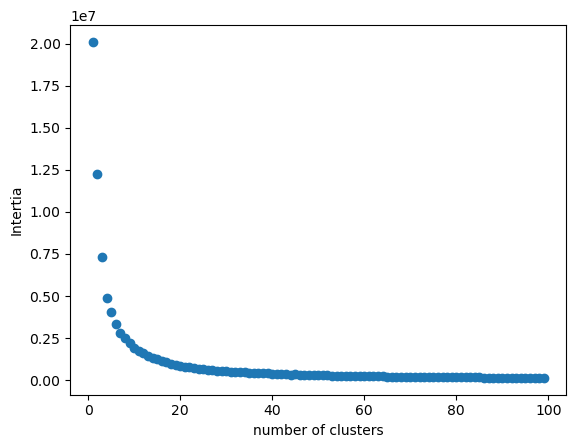

In [48]:
#Elbow plot to determine k neighbrs
x_cols = np.array(X_trans3)
inertia = []

Ks=range(1,100)

for k in Ks:
    model = KMeans(n_clusters = k)
    model.fit(x_cols)
    inertia.append(model.inertia_)

plt.scatter(Ks,inertia)
plt.xlabel("number of clusters")
plt.ylabel("Intertia")
plt.show()

In [49]:
#Create our KMEANS model but with 10 clusters
model = KMeans(n_clusters = 10, random_state = 10)
model.fit(x_cols)
labels = model.predict(x_cols)
labels.shape

Account_Num = us_data_sample.Sect.index

#create a table with the cluster_ID added to Account_Num
cluster_df = pd.DataFrame({'Account_Num':Account_Num, 'Cluster ID':labels})
cluster_df


Account_Num  Cluster ID
0               0           4
1               1           4
2               2           3
3               3           1
4               4           4
...           ...         ...
4946         4994           4
4947         4995           0
4948         4996           0
4949         4997           0
4950         4998           3

[4951 rows x 2 columns]

In [50]:
#expand the X,Y,Z
cluster_df['X']=X_trans3[:,0]
cluster_df['Y']=X_trans3[:,1]
cluster_df['Z']=X_trans3[:,2]
cluster_df

Account_Num  Cluster ID           X          Y          Z
0               0           4  -30.995903 -13.844243 -13.184941
1               1           4  -10.204629   0.706171 -11.292454
2               2           3   39.697150 -12.766251  -0.332479
3               3           1 -113.078438 -86.446384  48.421273
4               4           4  -37.361987  -0.766858 -13.290604
...           ...         ...         ...        ...        ...
4946         4994           4  -37.185309  22.604932  -8.941497
4947         4995           0   27.433091  -0.274625  -3.572642
4948         4996           0    5.308237 -19.318538 -18.748946
4949         4997           0   31.187418  -6.182952  -5.677998
4950         4998           3   62.761974 -10.626716  18.409048

[4951 rows x 5 columns]

In [51]:
# Create a 3D scatter plot

#article = https://towardsdatascience.com/isomap-embedding-an-awesome-approach-to-non-linear-dimensionality-reduction-fc7efbca47a0
fig = px.scatter_3d(cluster_df, 
                    x='X', 
                    y='Y',
                    z='Z',
                    color='Cluster ID',
                    height=900, width=900
                   )

# Update chart looks
fig.update_layout(#title_text="Scatter 3D Plot",
                  showlegend=True,
                  legend=dict(orientation="h", y=0, xanchor="center", x=0.5),
                  scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                        center=dict(x=0, y=0, z=-0.2),
                                        eye=dict(x=-1.5, y=1.5, z=0.5)),
                                        margin=dict(l=0, r=0, b=0, t=0),
                  scene = dict(xaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         ),
                               yaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                          ),
                               zaxis=dict(backgroundcolor='lightgrey',
                                          color='black', 
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         )))

# Update marker size
fig.update_traces(marker=dict(size=2))

fig.show()

##### 

## can we classify those clusters (per section)?

In [53]:
#dict to hold transformed vectors 
rows = []

for sector in us_data_sample.Sect.unique():
    #subset the data
    data = us_data_sample.loc[us_data_sample.Sect==sector]

    #nlp
    doc = list(nlp.pipe(data.Answer))
    
    #vectorize
    vectors=[tokens.vector for tokens in doc]
    
    #embed
    iso = Isomap(
    n_neighbors=5, # default=5, algorithm finds local structures based on the nearest neighbors
    n_components=3, # number of dimensions
    eigen_solver='auto', # {‘auto’, ‘arpack’, ‘dense’}, default=’auto’
    tol=0, # default=0, Convergence tolerance passed to arpack or lobpcg. not used if eigen_solver == ‘dense’.
    max_iter=None, # default=None, Maximum number of iterations for the arpack solver. not used if eigen_solver == ‘dense’.
    path_method='auto', # {‘auto’, ‘FW’, ‘D’}, default=’auto’, Method to use in finding shortest path.
    neighbors_algorithm='auto', # neighbors_algorithm{‘auto’, ‘brute’, ‘kd_tree’, ‘ball_tree’}, default=’auto’
    n_jobs=-1, # n_jobsint or None, default=None, The number of parallel jobs to run. -1 means using all processors
    metric='minkowski', # string, or callable, default=”minkowski”
    p=2, # default=2, Parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2
    metric_params=None # default=None, Additional keyword arguments for the metric function.
)
    X_trans = iso.fit_transform(vectors)
    

    model = KMeans(n_clusters = 3, random_state = 10)
    model.fit(X_trans)
    labels = model.predict(X_trans)
    
    
    # create a row dictionary for each value in X_trans
    for i in range(len(X_trans)):
        row = {
            'Account_Num': data.iloc[i]['Account_Num'],
            'Sector': sector,
            'X_trans': X_trans[i],
            'Label':labels[i]
        }
        rows.append(row)

# create a pandas DataFrame from the rows list
df = pd.DataFrame(rows)

df['X']=[arr[0] for arr in df.X_trans]
df['Y'] = [arr[1] for arr in df.X_trans]
df['Z'] = [arr[2] for arr in df.X_trans]
df.Label=df.Label.astype('str')
df['Sector-Label']= df['Sector']+'-'+df['Label']
df.sort_values(['Account_Num','Sector'])



Account_Num                     Sector  \
951          1184         Adaptation Actions   
1055         1184         Adaptation Actions   
1109         1184         Adaptation Actions   
1205         1184         Adaptation Actions   
1344         1184         Adaptation Actions   
...           ...                        ...   
3533       841964  Mitigation Target setting   
3576       841964  Mitigation Target setting   
3674       841964  Mitigation Target setting   
4533       841964              Opportunities   
4368       841964               Water Supply   

                                                X_trans Label          X  \
951   [16.382753061337766, -31.32763112468013, -6.99...     2  16.382753   
1055  [40.11622957946265, -23.53993550202771, 6.6579...     2  40.116230   
1109  [-20.531689667301766, -1.6381235631468114, -1....     0 -20.531690   
1205  [-73.78441405358099, -17.510315598316584, 1.58...     0 -73.784414   
1344  [26.799763947598194, 105.4122793262067, -57.39...     1  26.799764   
...                                                 ...   ...        ...   
3533  [-8.451698725832134, -0.35705031797424275, 1.9...     1  -8.451699   
3576  [-71.65644574369404, -80.60359460132437, -42.5...     1 -71.656446   
3674  [-5.032278326958968, -0.8181314876289492, 26.8...     1  -5.032278   
4533  [47.75453225665864, 53.73128247244307, -2.0278...     2  47.754532   
4368  [25.42065887004106, -21.278221541470035, -1.61...     2  25.420659   

               Y          Z                 Sector-Label  
951   -31.327631  -6.998388         Adaptation Actions-2  
1055  -23.539936   6.657925         Adaptation Actions-2  
1109   -1.638124  -1.662516         Adaptation Actions-0  
1205  -17.510316   1.580837         Adaptation Actions-0  
1344  105.412279 -57.390650         Adaptation Actions-1  
...          ...        ...                          ...  
3533   -0.357050   1.986316  Mitigation Target setting-1  
3576  -80.603595 -42.580141  Mitigation Target setting-1  
3674   -0.818131  26.893579  Mitigation Target setting-1  
4533   53.731282  -2.027883              Opportunities-2  
4368  -21.278222  -1.612652               Water Supply-2  

[4951 rows x 8 columns]

In [54]:
# Create a 3D scatter plot
fig = px.scatter_3d(df, 
                    x = 'X',
                    y = 'Y',
                    z = 'Z',
                    color='Sector-Label',
                    height=900, width=900
                   )

# Update chart looks
fig.update_layout(#title_text="Scatter 3D Plot",
                  showlegend=True,
                  legend=dict(orientation="h", y=0, xanchor="center", x=0.5, traceorder="normal"),
                  scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                        center=dict(x=0, y=0, z=-0.2),
                                        eye=dict(x=-1.5, y=1.5, z=0.5)),
                                        margin=dict(l=0, r=0, b=0, t=0),
                  scene = dict(xaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         ),
                               yaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                          ),
                               zaxis=dict(backgroundcolor='lightgrey',
                                          color='black', 
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         )))
# Update marker size
fig.update_traces(marker=dict(size=2))

fig.show()

Double click on Climate Hazards-0, Climate Hazards-1, and Climate Hazards-2. You'll see the groupings

## Analysis 4: Can we view these groupings on a map? 

In [55]:
#isolate dataframe to investigate climate hazards
climate_hazard_df = df.query("Sector=='Climate Hazards'")[['Account_Num','Label']].sort_values('Account_Num')

In [122]:
#merge with dim_cd_df to get the lat/ long
climate_hazard_df=climate_hazard_df.merge(dim_cd_df.query("Reporting_Year==2020")[['Account_Num','lat','long']],on='Account_Num',how='left')
climate_hazard_df.drop_duplicates()


Account_Num Label    lat_x   long_x    lat_y   long_y
0           1184     0  30.2672 -97.7431  30.2672 -97.7431
1           1184     1  30.2672 -97.7431  30.2672 -97.7431
4           1184     2  30.2672 -97.7431  30.2672 -97.7431
6           3203     1  41.8781 -87.6298  41.8781 -87.6298
9           3417     2  40.7128 -74.0059  40.7128 -74.0059
..           ...   ...      ...      ...      ...      ...
919        74594     0  26.4986 -80.2160  26.4986 -80.2160
930       832838     1  41.9305 -70.0310  41.9305 -70.0310
931       832838     2  41.9305 -70.0310  41.9305 -70.0310
934       841964     1  25.9812 -80.1484  25.9812 -80.1484
935       841964     2  25.9812 -80.1484  25.9812 -80.1484

[292 rows x 6 columns]

In [121]:
#Each account_Number may have several clustering lables. Lets find out which label is most common per account

#print out the counts for each label per account_Num
climate_hazard_df_counts=climate_hazard_df.groupby(['Account_Num','lat','long'],as_index=False)['Label'].value_counts()


#create our mask that we'll use to filter our data
mask = climate_hazard_df_counts.groupby('Account_Num',as_index=False)['count'].max()

#merge on mask and climate_hazard_df_counts to line up account_Num and counts
main_label_df = climate_hazard_df_counts.merge(mask,on=['Account_Num','count'])

main_label_df.sort_values('Account_Num')


Account_Num      lat      long Label  count
0           1184  30.2672  -97.7431     1      3
1           3203  41.8781  -87.6298     1      3
2           3417  40.7128  -74.0059     1      4
3          10495  36.1699 -115.1400     1      7
4          10894  34.0522 -118.2440     1      6
..           ...      ...       ...   ...    ...
126        74531  35.5000 -106.0000     2      4
127        74594  26.4986  -80.2160     1     12
128       832838  41.9305  -70.0310     1      2
129       832838  41.9305  -70.0310     2      2
130       841964  25.9812  -80.1484     1      6

[131 rows x 5 columns]

In [58]:
#Create a map of clusters around the US
import folium
#Create a map
map1 = folium.Map(
    tiles='cartodbpositron',
    zoom_start=100)

def set_marker_color(row):
    if row["Label"] == '0':
        return "blue"
    elif row["Label"] == '1':
        return "red"
    elif row["Label"] == '2':
        return "green"
    else:
        return "gray"

main_label_df.apply(lambda row:folium.CircleMarker(radius=3,location=[row["lat"], row["long"]],fill=False,color=set_marker_color(row)).add_to(map1),axis=1)

map1

The big problem was that the answers were clustered by Question ID, not by the mertits of the answer itself. This matters because we will have certain Account IDs with multiple clusters. I choice to display the cluster groups on the map above by assigning each account ID (within the Climate Hazards subsector) to whichever cluster was most promiment.

## Analysis 5: Lets break it all down by subsector and question ID

In [59]:
#Lets do cluster analysis on just one subsector to see if we can isolate clusters in the questions

In [60]:
data = us_data_sample.loc[us_data_sample.Sect=='Climate Hazards']
data

Year  Account_Num  Question_ID  \
0     2020        59633         8561   
11    2020        58530         8590   
14    2020        50566         8384   
22    2020        74594         8245   
34    2020        54114         8560   
...    ...          ...          ...   
4979  2020        35274         8590   
4985  2020        58513         8160   
4989  2020        54109         8237   
4991  2020        54110         7927   
4997  2020        50541         7775   

                                                 Answer  \
0     Especially with covid and recent fires, Lack o...   
11                                      Health outcomes   
14    Precipitation is expected to increase, and loc...   
22                                          Do not know   
34    Asheville is a small City of 90,000 but popula...   
...                                                 ...   
4979  Health outcomes, Health systems (service provi...   
4985                                         Increasing   
4989                                             Medium   
4991  Society / community & culture, Energy, Emergen...   
4997                                             Medium   

                       Country                  geometry             Sect  
0     United States of America  POINT (-122.031 36.9741)  Climate Hazards  
11    United States of America  POINT (-72.6144 42.3048)  Climate Hazards  
14    United States of America    POINT (-149.9 61.2181)  Climate Hazards  
22    United States of America   POINT (-80.216 26.4986)  Climate Hazards  
34    United States of America  POINT (-82.5515 35.5951)  Climate Hazards  
...                        ...                       ...              ...  
4979  United States of America  POINT (-70.2553 43.6615)  Climate Hazards  
4985  United States of America  POINT (-122.876 42.3265)  Climate Hazards  
4989  United States of America  POINT (-86.5264 39.1653)  Climate Hazards  
4991  United States of America  POINT (-118.481 34.0219)  Climate Hazards  
4997  United States of America   POINT (-79.792 36.0726)  Climate Hazards  

[942 rows x 7 columns]

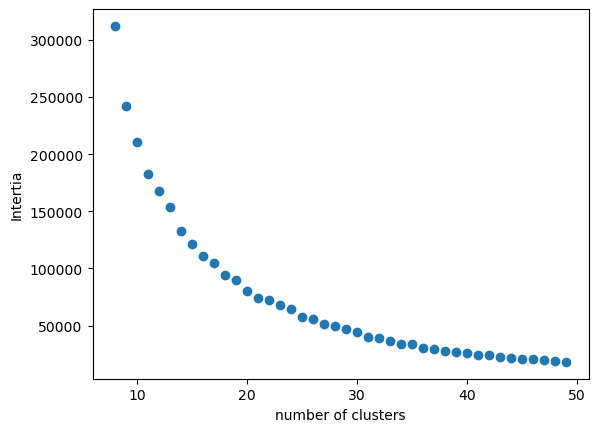

In [61]:
## Repeat as above but for just climate hazard

rows = []

    #subset the data
data = us_data_sample.loc[us_data_sample.Sect=='Climate Hazards']

#nlp
doc = list(nlp.pipe(data.Answer))
    
#vectorize
vectors=[tokens.vector for tokens in doc]
    
#embed
iso = Isomap(
n_neighbors=5, # default=5, algorithm finds local structures based on the nearest neighbors
n_components=3, # number of dimensions
eigen_solver='auto', # {‘auto’, ‘arpack’, ‘dense’}, default=’auto’
tol=0, # default=0, Convergence tolerance passed to arpack or lobpcg. not used if eigen_solver == ‘dense’.
max_iter=None, # default=None, Maximum number of iterations for the arpack solver. not used if eigen_solver == ‘dense’.
path_method='auto', # {‘auto’, ‘FW’, ‘D’}, default=’auto’, Method to use in finding shortest path.
neighbors_algorithm='auto', # neighbors_algorithm{‘auto’, ‘brute’, ‘kd_tree’, ‘ball_tree’}, default=’auto’
n_jobs=-1, # n_jobsint or None, default=None, The number of parallel jobs to run. -1 means using all processors
metric='minkowski', # string, or callable, default=”minkowski”
p=2, # default=2, Parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2
metric_params=None # default=None, Additional keyword arguments for the metric function.
)

X_trans = iso.fit_transform(vectors)


#Elbow plot to determine k neighbrs
x_cols = np.array(X_trans)
inertia = []

Ks=range(8,50)

for k in Ks:
    model = KMeans(n_clusters = k)
    model.fit(x_cols)
    inertia.append(model.inertia_)

plt.scatter(Ks,inertia)
plt.xlabel("number of clusters")
plt.ylabel("Intertia")
plt.show()


Looks like 11 to me

In [62]:
#Create our KMEANS model but with 20 clusters
model = KMeans(n_clusters = 20, random_state = 10)
model.fit(x_cols)
labels = model.predict(x_cols)
labels.shape

Account_Num = data.Account_Num
Question_ID = data.Question_ID

#create a table with the cluster_ID added to Account_Num
cluster_df = pd.DataFrame({'Account_Num':Account_Num,'Question_ID':Question_ID, 'Label':labels})
ch_cluster_df = cluster_df
ch_cluster_df

Account_Num  Question_ID  Label
0           59633         8561      5
11          58530         8590     18
14          50566         8384     19
22          74594         8245     12
34          54114         8560     19
...           ...          ...    ...
4979        35274         8590      7
4985        58513         8160      4
4989        54109         8237     10
4991        54110         7927     11
4997        50541         7775     10

[942 rows x 3 columns]

In [130]:
len(ch_cluster_df.Question_ID.unique())

202

In [63]:
ch_cluster_df['X'] = [array[0] for array in x_cols]
ch_cluster_df['Y'] = [array[1] for array in x_cols]
ch_cluster_df['Z'] = [array[2] for array in x_cols]
ch_cluster_df['Question_Label'] = (ch_cluster_df['Question_ID'].astype('str')) + '-' + (ch_cluster_df['Label'].astype('str'))
ch_cluster_df = ch_cluster_df.sort_values(['Question_ID','Label'])

In [64]:
# Create a 3D scatter plot
fig = px.scatter_3d(ch_cluster_df, 
                    x = 'X',
                    y = 'Y',
                    z = 'Z',
                    color='Label',
                    height=900, width=900
                   )

# Update chart looks
fig.update_layout(#title_text="Scatter 3D Plot",
                  showlegend=True,
                  legend=dict(orientation="h", y=0, xanchor="center", x=0.5, traceorder="normal"),
                  scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                        center=dict(x=0, y=0, z=-0.2),
                                        eye=dict(x=-1.5, y=1.5, z=0.5)),
                                        margin=dict(l=0, r=0, b=0, t=0),
                  scene = dict(xaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         ),
                               yaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                          ),
                               zaxis=dict(backgroundcolor='lightgrey',
                                          color='black', 
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         )))
# Update marker size
fig.update_traces(marker=dict(size=2))

fig.show()

In [65]:
pivot_df = ch_cluster_df.pivot(index='Account_Num', columns='Question_ID', values='Label')

In [66]:
pivot_df

Question_ID  7547  7548  7549  7550  7551  7552  7553  7554  7555  7557  ...  \
Account_Num                                                              ...   
1184          NaN   NaN   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3203          NaN   NaN   NaN   9.0   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3417          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
10495         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
10894         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
...           ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
74508         9.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
74531         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
74594         NaN   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
832838        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
841964        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

Question_ID  8653  8670  8671  8672  8673  8690  8691  8710  8711  8712  
Account_Num                                                              
1184          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3203          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3417          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
10495         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
10894         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
...           ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
74508         NaN  11.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
74531         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
74594         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
832838        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
841964        NaN  13.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[112 rows x 202 columns]

In [67]:
test = pivot_df.loc[:,7547]
test.dropna(inplace=True)
len(test.unique())

2

In [68]:
#How many unique cluster groups do we have per question?

In [69]:
unique_counts=[]
for col in pivot_df.columns:
    column = pivot_df.loc[:,col]
    column.dropna(inplace=True)
    un_values = len(column.unique())
    counts = {"Question_ID":col,
              "Num_Unique_Clusters":un_values}
    unique_counts.append(counts)
unique_counts_df = pd.DataFrame(unique_counts).sort_values('Num_Unique_Clusters',ascending=False)
unique_counts_df.set_index('Question_ID')

Num_Unique_Clusters
Question_ID                     
8467                           6
8465                           6
8469                           5
8468                           5
8466                           5
...                          ...
8079                           1
8011                           1
7938                           1
7935                           1
8712                           1

[202 rows x 1 columns]

<Figure size 640x480 with 0 Axes>

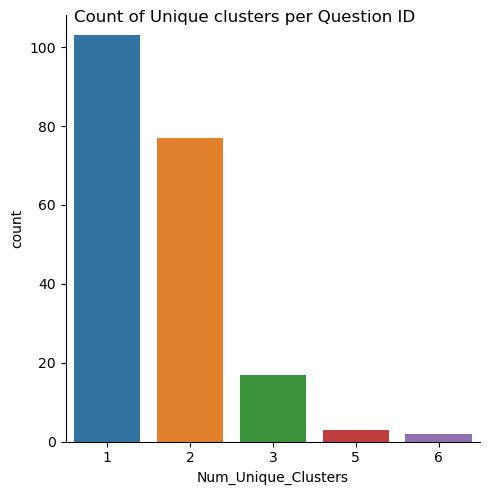

In [129]:
plt.clf() 
p=sns.catplot(kind='count',\
                  data=unique_counts_df,
                  x='Num_Unique_Clusters')
p.fig.suptitle('Count of Unique clusters per Question ID')
plt.show()

Lets see which questions have 4 and 5 clusters

In [71]:
custers_4_5_list = list(unique_counts_df.query('Num_Unique_Clusters in [4,5]').Question_ID)

In [72]:
dim_qq_df.loc[dim_qq_df.Question_ID.isin(custers_4_5_list)].merge(data[['Question_ID','Answer']],on='Question_ID').drop_duplicates().head()

Question_ID  Year                        Parent_Sect             Sect  \
0         8466  2020  Climate Hazards and Vulnerability  Climate Hazards   
1         8466  2020  Climate Hazards and Vulnerability  Climate Hazards   
2         8466  2020  Climate Hazards and Vulnerability  Climate Hazards   
3         8466  2020  Climate Hazards and Vulnerability  Climate Hazards   
5         8466  2020  Climate Hazards and Vulnerability  Climate Hazards   

  Q_Num                                             Q_Name  Col_Num  \
0   2.2  Please identify and describe the factors that ...        1   
1   2.2  Please identify and describe the factors that ...        1   
2   2.2  Please identify and describe the factors that ...        1   
3   2.2  Please identify and describe the factors that ...        1   
5   2.2  Please identify and describe the factors that ...        1   

                               Col_Name  Row_Num Row_Name  \
0  Factors that affect ability to adapt        2      NaN   
1  Factors that affect ability to adapt        2      NaN   
2  Factors that affect ability to adapt        2      NaN   
3  Factors that affect ability to adapt        2      NaN   
5  Factors that affect ability to adapt        2      NaN   

                    Answer  
0  Infrastructure capacity  
1                  Housing  
2                  Poverty  
3     Access to healthcare  
5       Economic diversity

## Analysis 6: A deeper dive into the open ended questions

In [73]:
#find answers that are over 1000 characters
us_subset = us_data_sample[['Question_ID','Answer','Sect']]
us_subset['Answer_length']=us_subset.apply(lambda row: len(row.Answer),axis=1)
us_subset = us_subset.sort_values('Answer_length',ascending=False).head(50)
over_1000_word_responses = us_subset.loc[us_subset.Answer_length > 1000] 
over_1000_word_responses = over_1000_word_responses.groupby(['Question_ID','Sect'],as_index=False)['Answer_length'].mean()
over_1000_word_responses.head()

Question_ID                Sect  Answer_length
0          892  Adaptation Actions         2052.5
1          900  Adaptation Actions         1109.0
2          910  Adaptation Actions         1284.0
3         2147    Adaptation Goals         1639.0
4         2149    Adaptation Goals         1439.0

In [74]:
over_1000_word_responses.shape[0]

40

In [75]:
over_1000_word_responses_list=list(over_1000_word_responses.Question_ID)

In [76]:
#subset us_data_Sample via the list above
open_ended_questions = us_data_sample.loc[us_data_sample.Question_ID.isin(over_1000_word_responses_list)]
open_ended_questions=open_ended_questions[['Account_Num','Question_ID','Sect','geometry','Answer']]
open_ended_questions

Account_Num  Question_ID                     Sect  \
5           49342         9913       Mitigation Actions   
14          50566         8384          Climate Hazards   
28          49342        20650  Water Supply Management   
47          59653        17181            Collaboration   
75          54109         2147         Adaptation Goals   
...           ...          ...                      ...   
4883        54124        14806               Governance   
4916        49339        20650  Water Supply Management   
4922        74401        15655               Governance   
4941        74423        18012            Opportunities   
4968        54100        20650  Water Supply Management   

                      geometry  \
5      POINT (-77.6109 43.161)   
14      POINT (-149.9 61.2181)   
28     POINT (-77.6109 43.161)   
47    POINT (-118.405 33.8889)   
75    POINT (-86.5264 39.1653)   
...                        ...   
4883  POINT (-121.989 37.5483)   
4916      POINT (157.59 21.28)   
4922  POINT (-117.293 33.0454)   
4941     POINT (24.5551 81.78)   
4968  POINT (-92.3341 38.9517)   

                                                 Answer  
5     The Rochester Eco-District project is not spea...  
14    Precipitation is expected to increase, and loc...  
28    The Climate Vulnerability Assessment identifie...  
47    California Green Business Network - Over 55 bu...  
75    Exact indicators will be established once the ...  
...                                                 ...  
4883  The General Plan specifically includes conserv...  
4916  The Honolulu Board of Water Supply and the Wat...  
4922                              City Manager's Office  
4941  Florida Keys Green Business Certification that...  
4968  Actions under consideration (currently seeking...  

[215 rows x 5 columns]

In [77]:
#create a dictionary of lemma per answer
def lemma_dict(row):

    doc=nlp(row.Answer)
    lemma_counts = defaultdict(int)
    for token in doc:
        if not token.is_punct and not token.is_stop: 
            lemma = token.lemma_
            if lemma in lemma_counts:
                lemma_counts[lemma] += 1
            else:
                lemma_counts[lemma] = 1
    return lemma_counts

In [78]:
open_ended_questions['Lemma_Count']=open_ended_questions.apply(lambda row: lemma_dict(row),axis=1)
open_ended_questions.sort_values('Question_ID')

Account_Num  Question_ID                     Sect  \
1633        54048          892       Adaptation Actions   
1173        54124          892       Adaptation Actions   
3183        59631          892       Adaptation Actions   
3354        54119          892       Adaptation Actions   
715         14344          892       Adaptation Actions   
...           ...          ...                      ...   
2054        14344        20650  Water Supply Management   
2058        43905        20650  Water Supply Management   
2303        35877        20650  Water Supply Management   
935         54075        20650  Water Supply Management   
4968        54100        20650  Water Supply Management   

                      geometry  \
1633  POINT (-83.9207 35.9606)   
1173  POINT (-121.989 37.5483)   
3183  POINT (-122.156 37.7249)   
3354  POINT (-122.143 37.4419)   
715   POINT (-111.498 40.6461)   
...                        ...   
2054  POINT (-111.498 40.6461)   
2058  POINT (-98.4936 29.4241)   
2303  POINT (-79.9959 40.4406)   
935   POINT (-105.081 39.7047)   
4968  POINT (-92.3341 38.9517)   

                                                 Answer  \
1633  This is reflective of two goals that involve e...   
1173  Three City of Fremont Fire Stations are benefi...   
3183  Flood mapping with State tools such as Cal-Ada...   
3354  Climate change is included in the Sustainabili...   
715   Scope:A new water treatment plant is under con...   
...                                                 ...   
2054  Residential water meters exist. Adding water m...   
2058  History and future projects1. Carrizo Water By...   
2303  The City of Pittsburgh and partners in the reg...   
935   Lakewood provides education information for th...   
4968  Actions under consideration (currently seeking...   

                                            Lemma_Count  
1633  {'reflective': 1, 'goal': 1, 'involve': 1, 'en...  
1173  {'City': 4, 'Fremont': 6, 'Fire': 3, 'Stations...  
3183  {'flood': 1, 'mapping': 1, 'state': 1, 'tool':...  
3354  {'climate': 1, 'change': 1, 'include': 1, 'Sus...  
715   {'scope': 1, 'new': 5, 'water': 11, 'treatment...  
...                                                 ...  
2054  {'residential': 1, 'water': 5, 'meter': 2, 'ex...  
2058  {'history': 1, 'future': 1, 'projects1': 1, 'C...  
2303  {'City': 2, 'Pittsburgh': 2, 'partner': 1, 're...  
935   {'Lakewood': 1, 'provide': 1, 'education': 1, ...  
4968  {'action': 1, 'consideration': 1, 'currently':...  

[215 rows x 6 columns]

In [79]:
#which questions have over 10 users answering them (since all quesitons are optional)
open_ended_questions_groupby = open_ended_questions.groupby('Question_ID')['Account_Num']\
                    .count()\
                    .sort_values(ascending=False)
open_ended_questions_groupby=open_ended_questions_groupby.loc[open_ended_questions_groupby.values>=10]

In [80]:
open_ended_questions_groupby

Question_ID
8731     15
14806    14
20650    11
18012    10
Name: Account_Num, dtype: int64

In [81]:
# pull out data where answers are atleast 1000 chars and 10 different people answered it

open_ended_questions_top_10 = open_ended_questions.query("Question_ID.isin(@open_ended_questions_groupby.index)")\
            .sort_values('Question_ID')
open_ended_questions_top_10.head()

Account_Num  Question_ID                                       Sect  \
2219        49327         8731  Climate Risk and Vulnerability Assessment   
3964        59653         8731  Climate Risk and Vulnerability Assessment   
3940        50551         8731  Climate Risk and Vulnerability Assessment   
3682        54092         8731  Climate Risk and Vulnerability Assessment   
4480        60656         8731  Climate Risk and Vulnerability Assessment   

                      geometry  \
2219   POINT (-71.4128 41.824)   
3964  POINT (-118.405 33.8889)   
3940  POINT (-118.194 33.7701)   
3682   POINT (-83.743 42.2808)   
4480  POINT (-122.232 37.8244)   

                                                 Answer  \
2219  An initial critical infrastructure and key res...   
3964  Completed Sea Level Rise Vulnerability Maps fo...   
3940  The climate vulnerability assessment is based ...   
3682  The Great Lakes Integrated Sciences + Assessme...   
4480  The City’s vulnerability assessment was comple...   

                                            Lemma_Count  
2219  {'initial': 1, 'critical': 1, 'infrastructure'...  
3964  {'complete': 1, 'Sea': 1, 'Level': 1, 'rise': ...  
3940  {'climate': 1, 'vulnerability': 2, 'assessment...  
3682  {'Great': 3, 'Lakes': 3, 'Integrated': 1, 'Sci...  
4480  {'City': 4, 'vulnerability': 2, 'assessment': ...

In [136]:
dim_qq_df.sort_values(['Sect','Q_Num','Col_Num','Row_Num'])

Question_ID  Year             Parent_Sect                     Sect  \
16032        16032  2018  Hazards and Adaptation               Adaptation   
16033        16033  2018  Hazards and Adaptation               Adaptation   
16034        16034  2018  Hazards and Adaptation               Adaptation   
16035        16035  2018  Hazards and Adaptation               Adaptation   
16036        16036  2018  Hazards and Adaptation               Adaptation   
...            ...   ...                     ...                      ...   
19166        19166  2018                   Water  Water Supply Management   
19167        19167  2018                   Water  Water Supply Management   
19168        19168  2018                   Water  Water Supply Management   
19169        19169  2018                   Water  Water Supply Management   
19170        19170  2018                   Water  Water Supply Management   

      Q_Num                                             Q_Name  Col_Num  \
16032   3.0  Has the Mayor or local government committed to...        0   
16033  3.0a  Please select the type of commitment and attac...        1   
16034  3.0a  Please select the type of commitment and attac...        1   
16035  3.0a  Please select the type of commitment and attac...        1   
16036  3.0a  Please select the type of commitment and attac...        1   
...     ...                                                ...      ...   
19166  15.4  Please select the actions you are taking to re...        3   
19167  15.4  Please select the actions you are taking to re...        3   
19168  15.4  Please select the actions you are taking to re...        3   
19169  15.4  Please select the actions you are taking to re...        3   
19170  15.4  Please select the actions you are taking to re...        3   

                                                Col_Name  Row_Num Row_Name  
16032                                                NaN        0      NaN  
16033  Type of commitment and attach commitment document        0      NaN  
16034  Type of commitment and attach commitment document        1      NaN  
16035  Type of commitment and attach commitment document        2      NaN  
16036  Type of commitment and attach commitment document        3      NaN  
...                                                  ...      ...      ...  
19166                                 Action description        8      NaN  
19167                                 Action description        9      NaN  
19168                                 Action description       10      NaN  
19169                                 Action description       11      NaN  
19170                                 Action description       12      NaN  

[22141 rows x 10 columns]